# Typová analýza

## Importy knihoven a definice pomocných funkcí

Následující buňky je potřeba spustit, aby vše fungovalo, jak má

In [1]:
import graphviz as gv
import nltk
import nltk.sem.logic as lg

In [2]:
def construct_tree(expression: nltk.sem.Expression):
    """Funkce, která výstup NLTK převede do stromové struktury.
    Funkce prozatím nepokrývá veškeré možnosti výstupu NLTK,
    pro naši potřebu je ale postačující.
    """
    tree = {"node": str(expression), "type": expression.type}

    if isinstance(expression, lg.ApplicationExpression):
        tree["children"] = [
            construct_tree(expression.function),
            construct_tree(expression.argument)
        ]
    elif isinstance(expression, lg.BinaryExpression):
        if isinstance(expression, lg.AndExpression):
            operand = "AND"
        elif isinstance(expression, lg.OrExpression):
            operand = "OR"
        elif isinstance(expression, lg.ImpExpression):
            operand = "=>"
        elif isinstance(expression, lg.IffExpression):
            operand = "<=>"
        tree["children"] = [
            construct_tree(expression.first),
            {"node": f"{operand} {expression.second}", "type": "<t,t>", "children": [{"node": operand, "type": "<t,<t,t>>"},construct_tree(expression.second)]}
        ]
    elif isinstance(expression, lg.NegatedExpression):
        tree["children"] = [
            {"node": "NOT", "type": "<t,t>"},
            construct_tree(expression.term)
        ]
    return tree

In [3]:
def id_generator():
    """Generátor unikátních ID - jsou níže použita pro jednoznačné identifikování uzlů v grafu
    """
    idx = 0
    while True:
        yield str(idx)
        idx += 1

def generate_graph(graph):
    """Ze stromové struktury vytvořené pomocí construct_tree vykreslí graf
    """
    dot = gv.Digraph(node_attr={"shape": "plaintext"}, edge_attr={"dir": "back"})
    nodeid = id_generator()
    root = next(nodeid)
    dot.node(root, f"{graph['node']}\ntyp: {graph['type']}")

    def add_level(parent, children, digraph, id_gen):
        for child in children:
            node = next(id_gen)
            digraph.node(node, f"{child['node']}\ntyp: {child['type']}")
            digraph.edge(parent, node)
            add_level(node, child.get("children", []), digraph, id_gen)

    add_level(root, graph.get("children", []), dot, nodeid)
    return dot

In [4]:
def type_analysis(expression, signature):
    """Funkce, která na základě zadaného výrazu a přiřazení typů vykreslí strom s typy.
    """
    expr = nltk.sem.Expression.fromstring(expression, signature=signature, type_check=True)
    tree = construct_tree(expr)
    return generate_graph(tree)

## Řešené příklady

### Příklad 1

* Věta: Vilda je velký.
* Výraz: `je_velký(Vilda)`
* Typy:
    * `Vilda` --> entita
    * `je_velký` --> intranzitivní predikát, tj. <e,t>

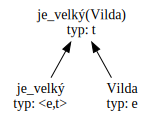

In [5]:
sig = {
    "Vilda": "e",
    "je_velký": "<e,t>",
}

type_analysis("je_velký(Vilda)", sig)

### Příklad 2
* Věta: Vilda kousnul Ferdu.
* Výraz: `kousnul(Vilda, Ferda)`
* Typy:
    * `Vilda` --> entita
    * `Ferda` --> entita
    * `kousnul` --> tranzitivní predikát <e,<e,t>>

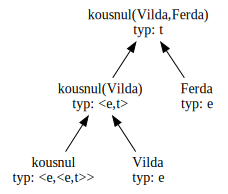

In [6]:
sig = {
    "Vilda": "e",
    "Ferda": "e",
    "kousnul": "<e,<e,t>>"
}

type_analysis("kousnul(Vilda, Ferda)", sig)

### Příklad 3

* Věta: Gentleman snědl vinnou klobásu.
* Výraz: `snědl(gentleman, vinná_klobása)`
* Typy:
    * `gentleman` --> entita (jedná se o argumentové čtení jmenné fráze)
    * `vinná_klobása` --> entita (opět se jedná o argumentové čtení jmenné fráze, není potřeba si to momentálně více komplikovat)
    * `snědl` --> tranzitivní predikát, tj. <e,<e,t>>
    

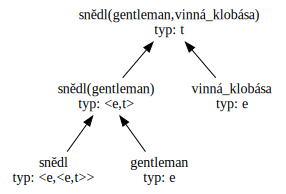

In [7]:
sig = {
    "gentleman": "e",
    "vinná_klobása": "e",
    "snědl": "<e,<e,t>>"
}

type_analysis("snědl(gentleman, vinná_klobása)", sig)

### Příklad 4
* Věta: Masaryk nejedl vinnou klobásu.
* Výraz: `-jedl(Masaryk, vinná_klobása)`
* Typy:
    * `Masaryk` --> entita
    * `vinná_klobása` --> entita
    * `jedl` --> tranzitivní predikát, tj. <e,<e,t>>
    * `-` --> negace, unární logická funkce, <t, t> (není potřeba psát do signatury, logické funkce jsou zpracovávány automaticky)

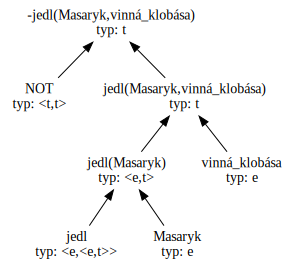

In [13]:
sig = {
    "Masaryk": "e",
    "vinná_klobása": "e",
    "jedl": "<e,<e,t>>",
    "-": "<t,t>"
}

type_analysis("-jedl(Masaryk, vinná_klobása)", sig)

### Příklad 5

* Věta: Masaryk nebo Beneš nosili čepici.
* Výraz: `nosil(Masaryk, čepice) | nosil(Beneš, čepice)` (symbol `|` je použitý pro logickou spojku "nebo")
* Typy:
    * `Masaryk` --> entita
    * `Beneš` --> entita
    * `čepice` --> entita
    * `nosil` --> tranzitivní predikát, <e,<e,t>>

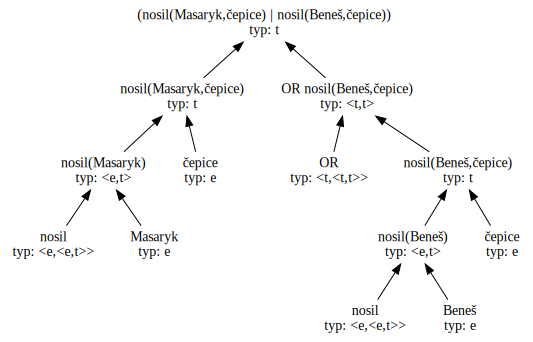

In [9]:
sig = {
    "Masaryk": "e",
    "Beneš": "e",
    "čepice": "e",
    "nosil": "<e,<e,t>>"
}

type_analysis("nosil(Masaryk, čepice) | nosil(Beneš, čepice)", sig)

Pro zájemce bych na tomto místě rád ukázal, jak se dá v případě typové analýzy pracovat přímo s NLTK.

In [ ]:
sig = {
    "Masaryk": "e",
    "Beneš": "e",
    "čepice": "e",
    "nosil": "<e,<e,t>>"
}

# zpracování reprezentace výrazu pomocí metody `fromstring`, type_check=True zapíná typovou kontrolu
expr = nltk.sem.Expression.fromstring("nosil(Masaryk, čepice) | nosil(Beneš, čepice)", signature=sig, type_check=True)
# a jak vypadá objekt, který funkce vrací?
expr

<OrExpression (nosil(Masaryk,čepice) | nosil(Beneš,čepice))>

In [ ]:
# OrExpression je reprezentací logické funkce OR, která má největší skopus.
# Obdobně pro logickou funkci AND existuje AndExpression, pro implikaci ImpExpression
# a pro ekvivalenci IffExpression
# Tyto reprezentace logických funkcí mají jednotlivé své argumenty uloženy pod vlastnostmi
# first a second
expr.first

<ApplicationExpression nosil(Masaryk,čepice)>

In [ ]:
expr.second

<ApplicationExpression nosil(Beneš,čepice)>

In [ ]:
# ApplicationExpression reprezentuje saturaci predikátu. Predikát je v objektu uložený
# pod vlastností function, argument pak pod vlastností argument

expr.second.function

<ApplicationExpression nosil(Beneš)>

In [ ]:
expr.second.argument

<ConstantExpression čepice>

In [ ]:
# V případě tranzitivních predikátů dochází k částečné aplikaci, tj.
# expr.second.function odpovídá opět ApplicationExpression.
# expr.second.argument je v tomto případě už ConstantExpression - konstanta, která
# se dále nijak nedělí. Pro všechny uzly je možné zjistit jejich typ

print(expr.second.argument.type)
print(expr.second.function.function.type)
print(expr.second.function.type)
print(expr.second.type)
print(expr.first.type)
print(expr.type)

e
<e,<e,t>>
<e,t>
t
t
t


## Příklady k procvičení

### Příklad 1

* Věta: Vilda je kocour.
* Výraz: `je_kocour(Vilda)`

In [ ]:
sig = {
    # sem doplňte typy
}

type_analysis("je_kocour(Vilda)", sig)

### Příklad 2

* Věta: Calvin stavěl sněhuláka.
* Výraz: `stavěl(Calvin, sněhulák)`

In [ ]:
sig = {
    # sem doplňte typy
}

type_analysis("stavěl(Calvin, sněhulák)", sig)

### Příklad 3

* Věta: Hobbes jedl tuňákovy sendvič.
* Výraz: `jedl(Hobbes, tuňákový_sendvič)`

In [ ]:
sig = {
    # sem doplňte typy
}

type_analysis("jedl(Hobbes, tuňákový_sendvič)", sig)

### Příklad 4

* Věta: Pokud Hobbes jedl tuňákový sendvič, tak Calvin stavěl sněhuláka.
* Výraz: `jedl(Hobbes, tuňákový_sendvič) => stavěl(Calvin, sněhulák)`

In [ ]:
sig = {
    # sem doplňte typy
}

type_analysis("jedl(Hobbes, tuňákový_sendvič) => stavěl(Calvin, sněhulák)", sig)

### Příklad 5

* Věta: Arthur Dent a Ford Prefekt jsou fanoušci vogonské poezie.
* Výraz: `je_fanoušek(Arthur_Dent, vogonská_poezie) & je_fanoušek(Ford_Prefekt, vogonská_poezie)`

In [ ]:
sig = {
    # sem doplňte typy
}

type_analysis("je_fanoušek(Arthur_Dent, vogonská_poezie) & je_fanoušek(Ford_Prefekt, vogonská_poezie)", sig)